In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Autoregressive Model</span>

In [2]:
msa_vmt = pd.read_csv('../../../results/historical_VMT_msa_basedon2022.csv',index_col=None) 
msa_vmt = msa_vmt.set_index('Year')
msa_vmt = msa_vmt[::-1]
msa_vmt

# Define new column names
new_column_names = ['New Haven (billion miles)', 'Hartford (billion miles)', 'Bridgeport (billion miles)']

# Assign new column names to the DataFrame
msa_vmt.columns = new_column_names

msa_vmt.index.name = 'year'


msa_vmt.index = pd.to_datetime(msa_vmt.index, format='%Y')
msa_vmt.index.freq = 'AS'
df=msa_vmt
df.to_csv('../../../data/tidy/vmt-msa-paper.csv')
df

,New Haven (billion miles),Hartford (billion miles),Bridgeport (billion miles)
year,,,
1966-01-01,3.180747,4.817869,3.284243
1967-01-01,3.265089,4.945621,3.371328
1968-01-01,3.480136,5.271353,3.593373
1969-01-01,3.658838,5.542031,3.777889
1970-01-01,3.831482,5.803535,3.956151
1971-01-01,3.988981,6.042099,4.118775
1972-01-01,4.146481,6.280663,4.281399
1973-01-01,4.291865,6.500876,4.431514
1974-01-01,4.194942,6.354068,4.331438


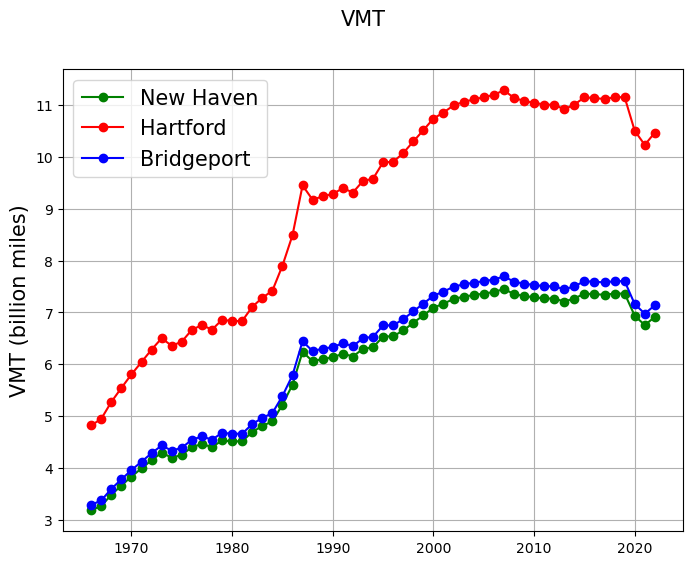

In [3]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('VMT',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (billion miles)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (billion miles)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (billion miles)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('VMT (billion miles)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/vmt-historical-change.png', dpi=600, bbox_inches='tight')

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Correlation and autocorrelation before and after differencing</span>

In [4]:
HEM_data = df['Hartford (billion miles)']
NHM_data = df['New Haven (billion miles)']
BSN_data = df['Bridgeport (billion miles)']

differenced_NHM = NHM_data.diff().dropna()
differenced_HEM = HEM_data.diff().dropna()
differenced_BSN = BSN_data.diff().dropna()

second_order_differenced_NHM = NHM_data.diff().diff().dropna()# the second order differencing will over difference the data

In [5]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [6]:
len(df_test)

11

In [7]:
import warnings
warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 
    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,8)
    d_values = range(1,3)
    q_values = range(0,8)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df

            
HEM_data = df['Hartford (billion miles)']
NHM_data = df['New Haven (billion miles)']
BSN_data = df['Bridgeport (billion miles)']
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_BSN_cv)

     p  d  q      MAPE       MAE      RMSE        BIC
0    0  1  0  2.214818  0.159740  0.229818 -28.184590
1    0  1  1  2.219652  0.160213  0.228161 -30.562095
2    0  1  2  2.236327  0.161621  0.225959 -29.525273
3    0  1  3  2.225160  0.160687  0.227290 -24.689445
4    0  1  4  2.337570  0.169921  0.218526 -22.179287
..  .. .. ..       ...       ...       ...        ...
123  7  2  3  3.918427  0.282940  0.394573  -0.721597
124  7  2  4  3.993305  0.289575  0.379190   1.961008
125  7  2  5  7.113276  0.517456  0.648948   1.769197
126  7  2  6  4.692914  0.339968  0.448994   5.674385
127  7  2  7  3.690103  0.267468  0.348478   8.297801

[128 rows x 7 columns]


In [8]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
BSN=test_BSN.sort_values(by='RMSE').iloc[:127,:]

In [9]:
BSN

MAPE       MAE      RMSE        BIC
p d q                                         
7 2 1  2.136723  0.157354  0.182647  -6.414820
    0  2.134009  0.157044  0.182684  -9.990871
6 2 3  2.170494  0.161077  0.187627  -0.236248
0 2 0  2.199249  0.163102  0.189295 -23.812233
1 2 0  2.199347  0.163126  0.189379 -30.942921
...         ...       ...       ...        ...
0 2 6  6.639032  0.481205  0.642453 -13.700144
7 2 5  7.113276  0.517456  0.648948   1.769197
0 2 5  6.780844  0.491603  0.653871 -16.448466
2 2 5  6.963949  0.505151  0.665703  -9.966968
4 2 6  7.344144  0.533678  0.680547  -2.874655

[127 rows x 4 columns]

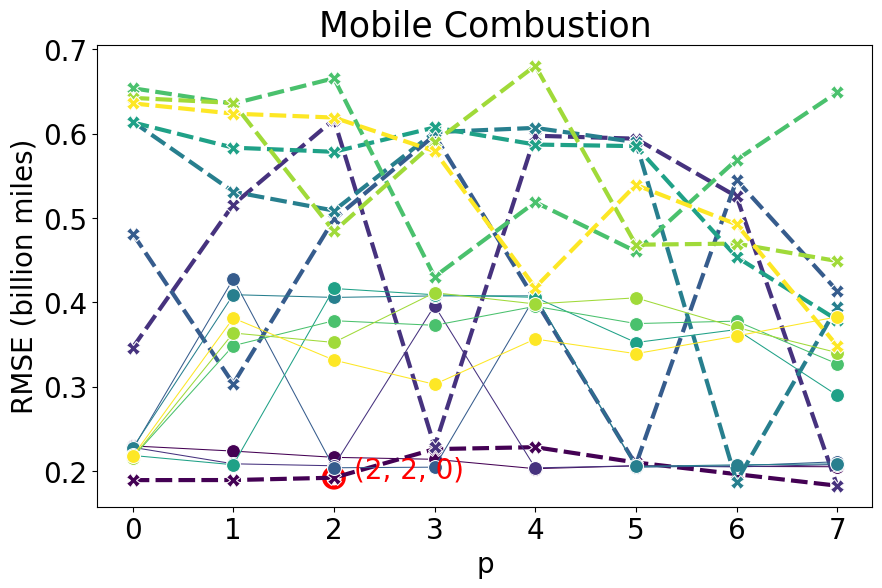

In [10]:
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=BSN ,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    #sizes=(200, 200),
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Mobile Combustion',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (billion miles)',fontsize=20)

 # Set x-ticks to display years from the start year
plt.xticks(range(8), fontsize=20)

# Set y-ticks to be integers and apply fontsize
max_y = 8  # Replace with your actual maximum value if different
plt.yticks( fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = BSN.loc[2, 2, 0]
p, d, q = 2, 2, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/mobile_emissions_BSN.jpg', dpi=600, bbox_inches='tight')

In [11]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
HEM=test_HEM.sort_values(by='BIC').iloc[:127,:]

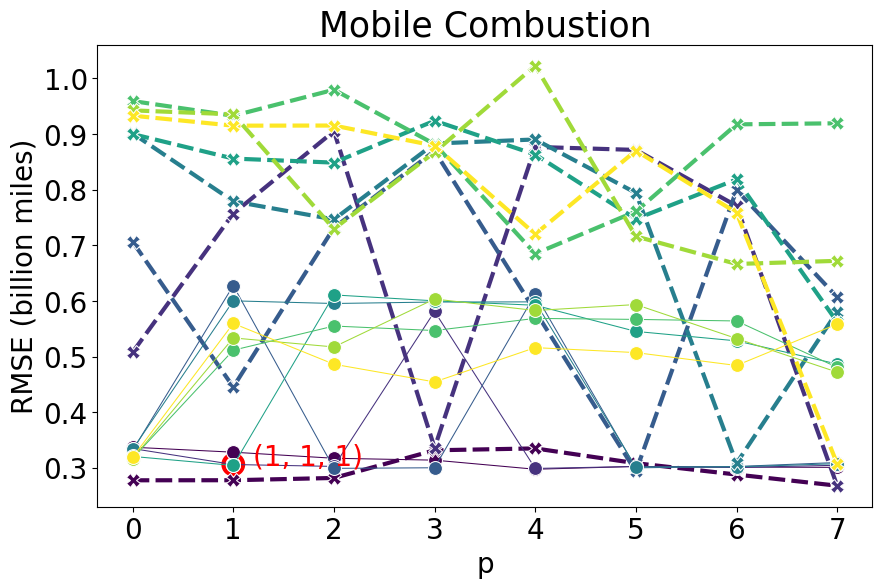

In [12]:
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=HEM ,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Mobile Combustion',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (billion miles)',fontsize=20)

plt.xticks(range(8), fontsize=20)
plt.yticks( fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = HEM.loc[1, 1, 1]
p, d, q = 1, 1, 1  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/mobile_emissions_HEM.jpg', dpi=600, bbox_inches='tight')

In [13]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
NHM=test_NHM.sort_values(by='RMSE').iloc[:127,:]

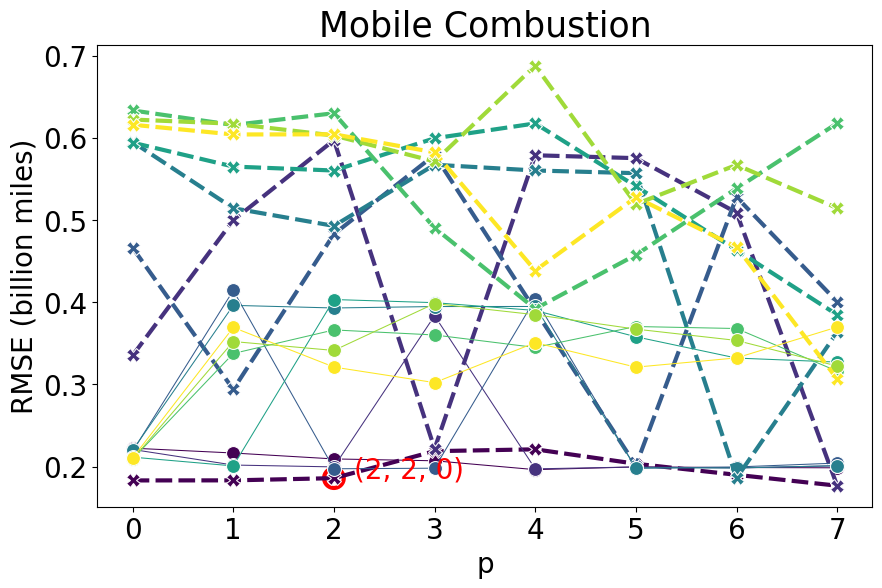

In [14]:
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=NHM,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Mobile Combustion',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (billion miles)',fontsize=20)

plt.xticks(range(8), fontsize=20)
plt.yticks( fontsize=20)

# Annotating the point (1, 2, 0) with a red hollow circle
highlight = NHM.loc[2, 2, 0]
p, d, q = 2, 2, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')
# Set y-axis limits explicitly
plt.savefig('../../../figures/rmse-plot/mobile_emissions_NHM.jpg', dpi=600, bbox_inches='tight')

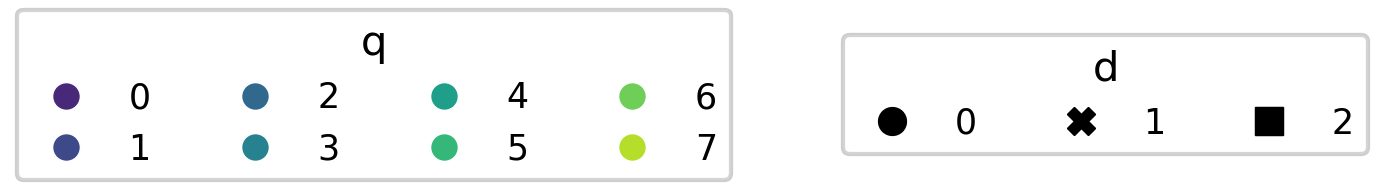

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Create the p legend (hue) handles
p_values = list(range(8))
colors = sns.color_palette("viridis", len(p_values))
p_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=20, label=f'{p}', linestyle='None')
             for p, color in zip(p_values, colors)]

# Create the d legend (style) handles
d_values = [0, 1, 2]
shapes = ['o', 'X', 's']
d_handles = [Line2D([0], [0], marker=shape, color='black', markersize=20, label=f'{d}', linestyle='None')
             for d, shape in zip(d_values, shapes)]

# Create a new figure for the legends
fig, ax = plt.subplots(figsize=(14, 2))

# Create the p (hue) legend
p_legend = fig.legend(
    handles=p_handles,
    loc='center left',
    frameon=True,
    fontsize=25,
    title="q",
    ncol=4  # Number of columns for horizontal layout
)

# Create the d (style) legend
d_legend = fig.legend(
    handles=d_handles,
    loc='center right',
    frameon=True,
    fontsize=25,
    title="d",
    ncol=len(d_values)  # Number of columns for horizontal layout
)

# Adjust legend properties
for legend in [p_legend, d_legend]:
    legend.get_frame().set_linewidth(3)  # Set legend frame linewidth
    title = legend.get_title()
    title.set_fontsize(30)  # Increase title font size

# Add the legends to the figure
fig.add_artist(p_legend)
fig.add_artist(d_legend)

# Remove the axes
ax.axis('off')



plt.savefig('../../../figures/rmse-plot/legends.jpg', dpi=600, bbox_inches='tight')


<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">VMT forecast</span>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Hartford (billion miles)   No. Observations:                   57
Model:                       ARIMA(1, 1, 1)   Log Likelihood                   6.888
Date:                      Thu, 30 May 2024   AIC                             -7.776
Time:                              12:16:37   BIC                             -1.809
Sample:                          01-01-1966   HQIC                            -5.475
                               - 01-01-2022                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9489      0.065     14.623      0.000       0.822       1.076
ma.L1         -0.8487      0.111     -7.667      0.000      -1.066      -0.632
sigma2         0.0448      0.005      8.542      0.000       0.034       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                39.06
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.41
Prob(H) (two-sided):                  0.85   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

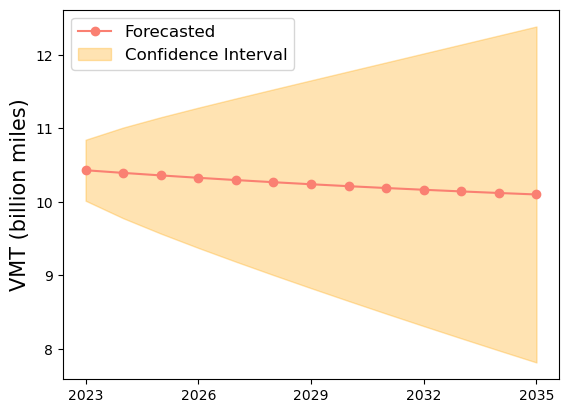

In [16]:
#In the arima model,p refers to how many previous/lagged Y values are accounted for for each time point in our model, and q refers to how many previous/lagged error values 
#are accounted for for each time point in our model

def arima_forecast(train, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
HEM_data = df['Hartford (billion miles)']
plot_file = '../../../figures/hartford-forecast-vmt.png'  # File to save the plot

summary, HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data,(1,1,1),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function
summary.summary()

#moel has most generalization;
#which one give the model that most signicance

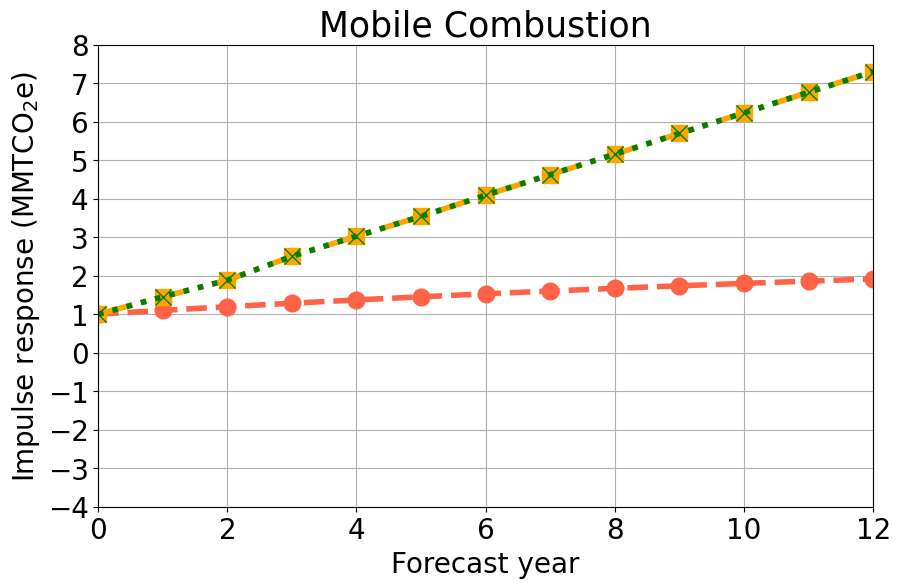

In [17]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def arima_forecast_1(train, order, forecast_horizon, plot_file, color1, color2):
    # Fit the ARIMA model with the specified order
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Forecasting
    forecast = res.forecast(steps=forecast_horizon)
    forecast.index = range(2023, 2023 + forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    # Impulse Response Calculation
    impulse_responses = res.impulse_responses(steps=forecast_horizon, impulse=0, orthogonalized=False, cumulative=False, anchor='end')
    
    # Ensure the length of impulse_responses matches the forecast_horizon
    impulse_responses = impulse_responses[:forecast_horizon]
    
    return res, forecast, confidence_interval, impulse_responses

def plot_multiple_irfs(irf_data, forecast_horizon, start_year, plot_file):
    plt.figure(figsize=(10, 6))
    
    for region, irf in irf_data.items():
        plt.plot(
            range(0, forecast_horizon),
            irf['impulse_responses'],
            marker=irf.get('marker', 'o'),  # default marker if 'marker' key is missing
            label=f'{region}',
            color=irf.get('color', None),  # default color if 'color' key is missing
            linestyle=irf.get('linestyle', '-'),  # default linestyle if 'linestyle' key is missing
            linewidth=irf.get('linewidth', 2),  # default linewidth if 'linewidth' key is missing
            alpha=irf.get('alpha', 0.7),  # default alpha if 'alpha' key is missing
            markersize=irf.get('markersize', 6)  # default markersize if 'markersize' key is missing
        )
    
    plt.ylabel('Impulse response (MMTCO$_2$e)', fontsize=20)
    plt.xlabel('Forecast year', fontsize=20)
    plt.title('Mobile Combustion', fontsize=25)
    plt.grid(True)
    
    # Set x-ticks to display years from the start year
    plt.xticks(range(0, forecast_horizon, 2), fontsize=20)
    
    # Set y-ticks to be integers and apply fontsize
    max_y = 8  # Replace with your actual maximum value if different
    plt.yticks(range(-4, max_y + 1), fontsize=20)
    
    # Set y-axis limits explicitly
    plt.ylim(-4, 8)

    # Adjust the spacing and save the plot
    plt.margins(x=0, y=0)
    plt.savefig(plot_file, dpi=600, bbox_inches='tight')

# Assuming df is your DataFrame and it contains columns for each region
regions = {
    'Hartford': {
        'data': df['Hartford (billion miles)'],
        'order': (1, 1, 1),
        'color': 'tomato',
        'marker': 'o',
        'linestyle': '--',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12  # Specify marker size
    },
    'New Haven': {
        'data': df['New Haven (billion miles)'],
        'order': (2, 2, 0),
        'color': 'orange',
        'marker': 's',
        'linestyle': '-.',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12  # Specify marker size
    },
    'Bridgeport': {
        'data': df['Bridgeport (billion miles)'],
        'order': (2, 2, 0),
        'color': 'green', 
        'marker': 'x',
        'linestyle': ':',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12  # Specify marker size
    }
}

forecast_horizon = 13
start_year = 2023
irf_data = {}

for region, params in regions.items():
    #plot_file = f'../../../figures/{region.lower().replace(" ", "")}-forecast-vmt.png'
    summary, forecast, confidence_interval, impulse_responses = arima_forecast_1(params['data'], params['order'], forecast_horizon, plot_file, params['color'], params['color'])
    irf_data[region] = {
        'impulse_responses': impulse_responses,
        'color': params['color'],
        'marker': params['marker'],  # Adding marker information
        'linestyle': params['linestyle'],  # Adding linestyle information
        'linewidth': params['linewidth'],  # Adding linewidth information
        'alpha': params['alpha'],  # Adding alpha information
        'markersize': params['markersize']  # Adding markersize information
    }

# Plot all impulse response functions together
irf_plot_file = '../../../figures/impulse-function/mobile-IRF.jpg'
plot_multiple_irfs(irf_data, forecast_horizon, start_year, irf_plot_file)


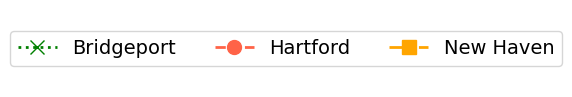

In [18]:
import matplotlib.lines as mlines
# Function to plot the legend separately
# Function to plot the legend separately
def plot_legend(legend_file):
    # Create a dummy plot with larger figure size
    plt.figure(figsize=(1, 1))  # Adjust the figure size as needed

    # Create legend handles and labels
    legend_handles = []
    for region, params in regions.items():
        line = mlines.Line2D([], [], color=params['color'], linestyle=params['linestyle'], linewidth=params['linewidth'], marker=params['marker'], markersize=10, label=region)
        legend_handles.append(line)

    # Plot legend with adjusted bbox_to_anchor
    plt.legend(handles=legend_handles, loc='center', fontsize=14, ncol=3, bbox_to_anchor=(0.5, 0.5))  # Increase fontsize and set ncol=3 for three columns
    plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(legend_file, dpi=600, bbox_inches='tight')
regions = {
    'Bridgeport': {
        'color': 'green',
        'marker': 'x',
        'linestyle': ':',
        'linewidth': 2
    },
    'Hartford': {
        'color': 'tomato',
        'marker': 'o',
        'linestyle': '--',
        'linewidth': 2
    },
    'New Haven': {
        'color': 'orange',
        'marker': 's',
        'linestyle': '-.',
        'linewidth': 2
    },
}

# Plot the legend separately
legend_file = '../../../figures/impulse-function/IRF-legend.jpg'
plot_legend(legend_file)


In [19]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape

HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(1,1,1))
print(mae)
print(rmse)
print(mape)

0.23987535916675737
0.30604105904360973
2.247195072949534


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     New Haven (billion miles)   No. Observations:                   57
Model:                        ARIMA(2, 2, 0)   Log Likelihood                  23.674
Date:                       Thu, 30 May 2024   AIC                            -41.349
Time:                               12:16:38   BIC                            -35.438
Sample:                           01-01-1966   HQIC                           -39.076
                                - 01-01-2022                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5475      0.134     -4.084      0.000      -0.810      -0.285
ar.L2         -0.3205      0.122     -2.621      0.009      -0.560      -0.081
sigma2         0.0240      0.003      7.894      0.000       0.018       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                81.05
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -1.31
Prob(H) (two-sided):                  0.94   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

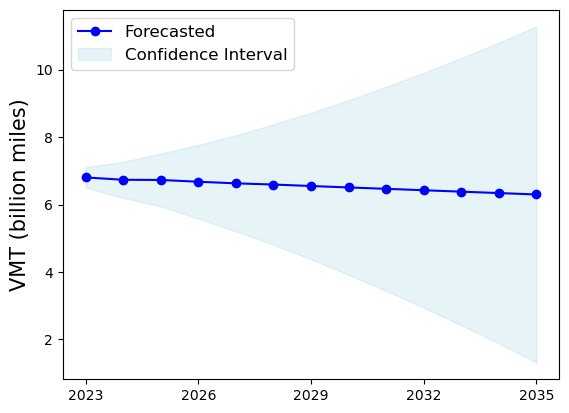

In [20]:
NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
NHM_data = df['New Haven (billion miles)']
plot_file = '../../../figures/newhaven-forecast-VMT.png'  # File to save the plot


summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data,(2,2,0),13, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [21]:
summary.pvalues

ar.L1     4.430952e-05
ar.L2     8.771914e-03
sigma2    2.933535e-15
dtype: float64

In [22]:
NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
NHM_data = df['New Haven (billion miles)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(0,2,8))
print(mae, rmse, mape)

0.1313347716737011 0.1650831055548571 1.8122673997818723


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Bridgeport (billion miles)   No. Observations:                   57
Model:                         ARIMA(2, 2, 0)   Log Likelihood                  21.977
Date:                        Thu, 30 May 2024   AIC                            -37.954
Time:                                12:16:39   BIC                            -32.044
Sample:                            01-01-1966   HQIC                           -35.681
                                 - 01-01-2022                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5475      0.134     -4.084      0.000      -0.810      -0.285
ar.L2         -0.3205      0.122     -2.621      0.009      -0.560      -0.081
sigma2         0.0255      0.003      7.894      0.000       0.019       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                81.05
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -1.31
Prob(H) (two-sided):                  0.94   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

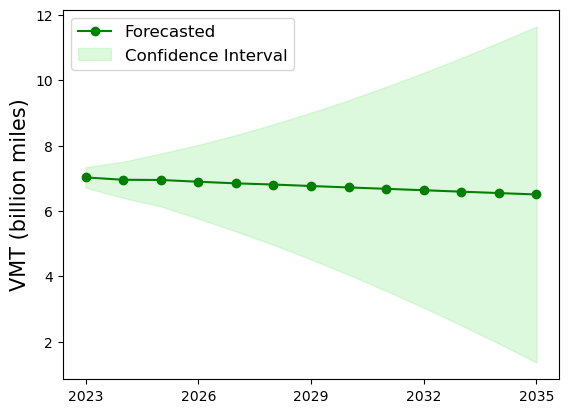

In [23]:
BSN_train = df_train['Bridgeport (billion miles)']
BSN_test = df_test['Bridgeport (billion miles)']
BSN_data = df['Bridgeport (billion miles)']
plot_file = '../../../figures/bridgeport-forecast-VMT.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data,(2,2,0),13, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [24]:
summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Bridgeport (billion miles)   No. Observations:                   57
Model:                         ARIMA(2, 2, 0)   Log Likelihood                  21.977
Date:                        Thu, 30 May 2024   AIC                            -37.954
Time:                                12:16:39   BIC                            -32.044
Sample:                            01-01-1966   HQIC                           -35.681
                                 - 01-01-2022                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5475      0.134     -4.084      0.000      -0.810      -0.285
ar.L2         -0.3205      0.122     -2.621      0.009      -0.560      -0.081
sigma2         0.0255      0.003      7.894      0.000       0.019       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                81.05
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -1.31
Prob(H) (two-sided):                  0.94   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(7,2,1))
print(mae,rmse, mape)

0.15735359007240868 0.18264690297400848 2.1367233751365045


<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Emissions calculation</span>

In [26]:
import string
df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

statewide_vehicle = df_vehicle_re.iloc[14, :]

# the total number of each vehicle type
statewide_automobile = statewide_vehicle.iloc[3]
statewide_buses = statewide_vehicle.iloc[6]
statewide_trucks = statewide_vehicle.iloc[9]
statewide_motorcycle = statewide_vehicle.iloc[12]
statewide_total = statewide_vehicle.iloc[15]

# ratio of each vehicle type to the total
statewide_automobile = int(str(statewide_automobile).translate(str.maketrans('', '', string.punctuation)))
statewide_buses = int(str(statewide_buses).translate(str.maketrans('', '', string.punctuation)))
statewide_trucks = int(str(statewide_trucks).translate(str.maketrans('', '', string.punctuation)))
statewide_motorcycle = int(str(statewide_motorcycle).translate(str.maketrans('', '', string.punctuation)))
statewide_total = int(str(statewide_total).translate(str.maketrans('', '', string.punctuation)))

automobile_rat = statewide_automobile / statewide_total
buses_rat = statewide_buses / statewide_total
trucks_rat = statewide_trucks / statewide_total
motorcycle_rat = statewide_motorcycle / statewide_total

statewide_vehicle = statewide_vehicle.to_numpy()

In [27]:
def emissions(VMT):
    automobile_vmt=VMT*automobile_rat
    buses_vmt=VMT*buses_rat
    trucks_vmt=VMT*trucks_rat
    motorcycle_vmt=VMT*motorcycle_rat

    #average MPG for each vehicle type ( miles per gallons)
    passenger_car_gasoline=24.1#automobile
    passenger_car_diesel=32.4
    light_truck_gasoline=18.5
    light_truck_diesel=22.1#trucks
    heavy_duty_gasoline=10.13
    heavy_duty_diesel=12.96#buses
    motorcycle_gasoline=50#motorcycle

    #emission factor for different fuels (kg CO2/gallon)( referenced from the ghg tool community module)
    gasoline=8.78
    diesel=10.21

    #calculate the fuel consumption in NH MSA
    gaso_consump= automobile_vmt/passenger_car_gasoline+motorcycle_vmt/motorcycle_gasoline
    dies_consump= buses_vmt/heavy_duty_diesel+trucks_vmt/light_truck_diesel

    #calcualte the gasoline and diesel emissions: carbon dioxide emissions only
    gaso_emissions =gaso_consump*gasoline/1000
    dies_emissions =dies_consump*diesel/1000

    #calculate the carbon dioxide consumption(metric tons):
    CO2=gaso_consump*gasoline/1000+dies_consump*diesel/1000

    gaso_auto=automobile_vmt/passenger_car_gasoline
    gaso_motor=motorcycle_vmt/motorcycle_gasoline
    die_trucks=trucks_vmt/light_truck_diesel
    die_buses=buses_vmt/heavy_duty_diesel

    #emission factor for different vehicles : g/miles ( referenced from EPA emission hub)
    # based on year 2005
    CH4_gaso_passenger_car=0.008
    N2O_gaso_passenger_car=0.007

    CH4_gaso_motorcycle=0
    N2O_gaso_motorcycle=0

    CH4_buses=0.005
    N2O_buses=0.005 #( meidum- heavy-duty vehicles in year 2005)

    CH4_trucks=0.001 #( light-duty trucks)
    N2O_trucks=0.001

    #calculate the CH4 emission (metric tons):
    CH4=automobile_vmt*CH4_gaso_passenger_car/1000000+motorcycle_vmt*CH4_gaso_motorcycle/1000000+buses_vmt*CH4_buses/1000000+trucks_vmt*CH4_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_1=CH4*25

    #calculate the N2O emission (metric tons):
    N2O = automobile_vmt*N2O_gaso_passenger_car/1000000 + motorcycle_vmt*N2O_gaso_motorcycle/1000000+buses_vmt*N2O_buses/1000000+trucks_vmt*N2O_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_2=N2O*298#define the number 

    #calculation of emissions from each types of vehicle,MMTCO2e(autombile, motorcycle, trucks, buses-NH,HH,BSN)
    automobile = (automobile_vmt/passenger_car_gasoline*gasoline/1000+automobile_vmt*CH4_gaso_passenger_car/1000000*25+automobile_vmt*N2O_gaso_passenger_car/1000000*298)*1000
    motorcycle = (motorcycle_vmt/motorcycle_gasoline*gasoline/1000+motorcycle_vmt*CH4_gaso_motorcycle/1000000*25+motorcycle_vmt*N2O_gaso_motorcycle/1000000*298)*1000
    buses = (buses_vmt/heavy_duty_diesel*diesel/1000+buses_vmt*CH4_buses/1000000*25+buses_vmt*N2O_buses/1000000*298)*1000
    trucks = (trucks_vmt/light_truck_diesel*diesel/1000+trucks_vmt*CH4_trucks/1000000*25+trucks_vmt*N2O_trucks/1000000*298)*1000

    total = automobile+motorcycle+buses+trucks
    
    return total

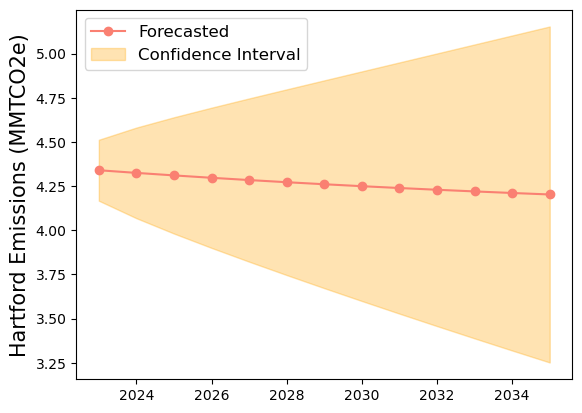

In [28]:
def VMT_plot(area, confidence_int,plot_title,plot_file, color1, color2):
    forecasted = emissions(area)
    confidence_interval_emissions = emissions(confidence_int)
    # Plot the forecasted values
    plt.plot(forecasted.index, forecasted, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecasted.index, confidence_interval_emissions.iloc[:, 0], confidence_interval_emissions.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel(plot_title, fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    plt.savefig(plot_file, dpi=600, bbox_inches='tight')
    
    return forecasted
    
plot_title = 'Hartford Emissions (MMTCO2e)'
plot_file = '../../../figures/hartford-forecast-emissions.png'  # File to save the plot
HEM_emissions_forecast=VMT_plot(HEM_forecast,HEM_confidence_interval,plot_title,plot_file,'salmon','orange')

In [29]:
HEM_emissions_forecast

2023    4.339532
2024    4.324528
2025    4.310290
2026    4.296780
2027    4.283960
2028    4.271795
2029    4.260252
2030    4.249298
2031    4.238904
2032    4.229041
2033    4.219682
2034    4.210801
2035    4.202374
Name: predicted_mean, dtype: float64

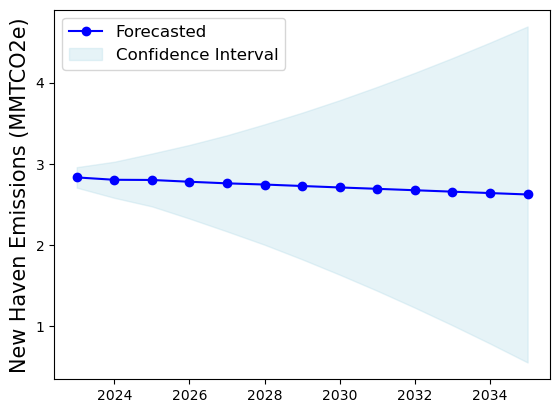

In [30]:
plot_title = 'New Haven Emissions (MMTCO2e)'
plot_file = '../../../figures/newhaven-forecast-emissions.png'  # File to save the plot
NHM_emissions_forecast=VMT_plot(NHM_forecast,NHM_confidence_interval,plot_title,plot_file,'blue','lightblue')

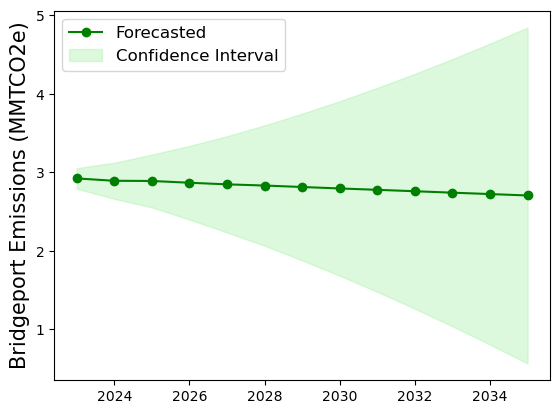

In [31]:
plot_title = 'Bridgeport Emissions (MMTCO2e)'
plot_file = '../../../figures/bridgeport-forecast-emissions.png'  # File to save the plot
BSN_emissions_forecast=VMT_plot(BSN_forecast,BSN_confidence_interval,plot_title,plot_file,'green','lightgreen')

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Fitting training data</span>

In [32]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean
    train_conf_int = train_forecast.conf_int()
        
    #train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    #train_conf_int = train_forecast.conf_int().iloc[

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()

    emissions_train = emissions(train_forecast_mean)
    
    train_conf_int = emissions(train_conf_int)
    
    return emissions_train,train_conf_int
    
    
HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(1,1,1))

NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(2,2,0))

BSN_train = df_train['Bridgeport (billion miles)']
BSN_test = df_test['Bridgeport (billion miles)']
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(2,2,0))

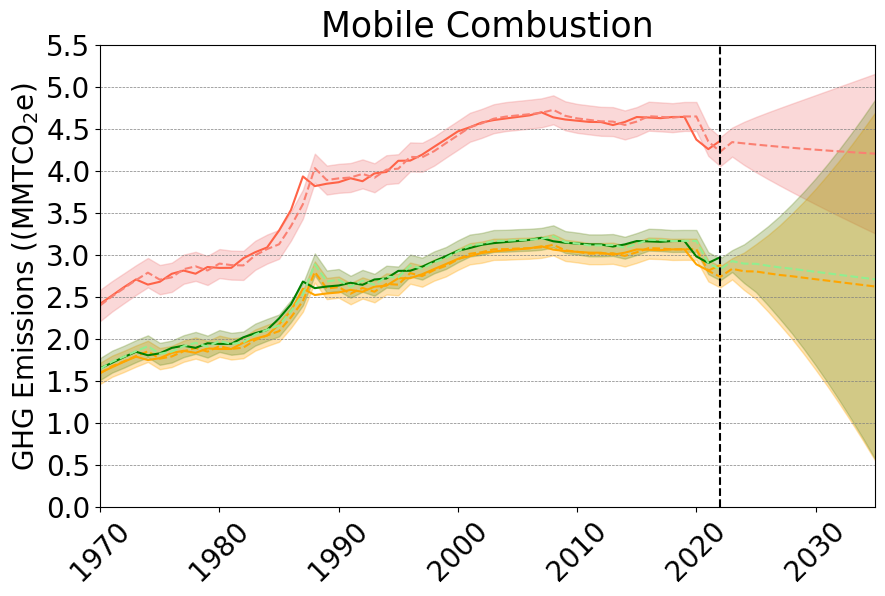

In [39]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([emissions(HEM_train),emissions(HEM_test)])
HEM_emissions_forecast.index = pd.to_datetime(HEM_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM[1:],HEM_emissions_forecast])

#HEM_emissions_forecast.index = pd.to_datetime(HEM_emissions_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM[4:].index, concatenated_observed_HEM[4:],label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM[3:].index, concatenated_predicted_forecast_HEM[3:], label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, emissions(HEM_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_HEM[4:].index, concatenated_confidence_interval_HEM.iloc[4:, 0], concatenated_confidence_interval_HEM.iloc[4:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([emissions(NHM_train),emissions(NHM_test)])
NHM_emissions_forecast.index = pd.to_datetime(NHM_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM[1:],NHM_emissions_forecast])

plt.plot(concatenated_observed_NHM[4:].index, concatenated_observed_NHM[4:],label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM[3:].index, concatenated_predicted_forecast_NHM[3:], label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, emissions(NHM_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_NHM[4:].index, concatenated_confidence_interval_NHM.iloc[4:, 0], concatenated_confidence_interval_NHM.iloc[4:, 1], color='orange', alpha=0.3)

#plt.plot(NHM_emissions_forecast.index, NHM_emissions_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
#plt.fill_between(NHM_emissions_forecast.index, emissions(NHM_confidence_interval).iloc[:, 0], emissions(NHM_confidence_interval).iloc[:, 1], color='darkturquoise', alpha=0.3)
#plt.fill_between(emissions_train_NHM[10:].index, train_conf_int_NHM.iloc[10:, 0], train_conf_int_NHM.iloc[10:, 1], color='darkturquoise', alpha=0.3)


concatenated_observed_BSN = pd.concat([emissions(BSN_train),emissions(BSN_test)])
BSN_emissions_forecast.index = pd.to_datetime(BSN_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN[1:],BSN_emissions_forecast])

plt.plot(concatenated_observed_BSN[4:].index, concatenated_observed_BSN[4:],label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN[3:].index, concatenated_predicted_forecast_BSN[3:], label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, emissions(BSN_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_BSN[4:].index, concatenated_confidence_interval_BSN.iloc[4:, 0], concatenated_confidence_interval_BSN.iloc[4:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Region')
deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Region')
green_patch = mpatches.Patch(color='green', label='Bridgeport Region')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch,green_patch], title="", fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
#plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=20, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Mobile Combustion', fontsize=25)
plt.ylabel('GHG Emissions ((MMTCO$_2$e)', fontsize=20)

# Set the x-axis ticks


plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set starting and ending dates for x-axis ticks
#plt.xlim(datetime.datetime(1970, 1, 1), datetime.datetime(2035, 1, 1))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')

#plt.figure(figsize=(14, 8))  # Adjust the figure size as needed

# Adjust the range of the x-axis to include 2035
plt.xlim(datetime.datetime(1970, 1, 1), datetime.datetime(2035, 1, 1))


# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)


max_y_value = 6
plt.yticks(np.arange(0, max_y_value, 0.5))


plt.savefig('../../../figures/forecast/mobile_emissions_forecast.jpg', dpi=600, bbox_inches='tight')


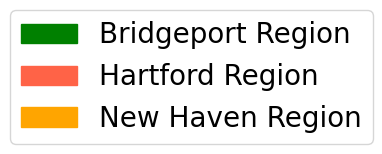

In [34]:
# Create a dummy plot
plt.figure(figsize=(1, 1))  # Set a small figure size
plt.axis('off')  # Turn off axis

# Create legend handles and labels
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Region')
deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Region')
green_patch = mpatches.Patch(color='green', label='Bridgeport Region')
#solid_line = mlines.Line2D([], [], color='black', label='Observed')
#dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
#alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')

# Plot legend
plt.legend(handles=[green_patch,tomato_patch, deepskyblue_patch],
           loc='center', fontsize=20)
plt.savefig('../../../figures/legend_1.png', dpi=600, bbox_inches='tight')

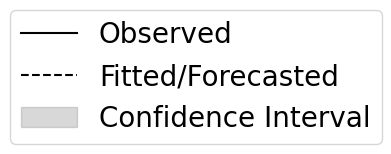

In [35]:
# Create a dummy plot
plt.figure(figsize=(1, 1))  # Set a small figure size
plt.axis('off')  # Turn off axis

# Create legend handles and labels
# tomato_patch = mpatches.Patch(color='tomato', label='Hartford Region')
# deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Region')
# green_patch = mpatches.Patch(color='green', label='Bridgeport Region')
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')

# Plot legend
plt.legend(handles=[solid_line, dashed_line, alpha_patch],
           loc='center', fontsize=20)
plt.savefig('../../../figures/legend_2.png', dpi=600, bbox_inches='tight')

In [36]:
concatenated_confidence_interval_HEM[4:].index.yea

AttributeError: 'DatetimeIndex' object has no attribute 'yea'

In [ ]:
concatenated_confidence_interval_HEM

In [ ]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM['upper Hartford (billion miles)'] - concatenated_confidence_interval_HEM['lower Hartford (billion miles)']) / 2
concatenated_confidence_interval_HEM

In [ ]:
concatenated_confidence_interval_NHM

In [ ]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM['upper New Haven (billion miles)'] - concatenated_confidence_interval_NHM['lower New Haven (billion miles)']) / 2
concatenated_confidence_interval_NHM

In [ ]:
concatenated_confidence_interval_BSN

In [ ]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN['upper Bridgeport (billion miles)'] - concatenated_confidence_interval_BSN['lower Bridgeport (billion miles)']) / 2
concatenated_confidence_interval_BSN

In [ ]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2035'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

In [ ]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

In [ ]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data